# Your first CNN on CIFAR-10

In this task you will: 
* define your first CNN architecture for CIFAR-10 dataset
* train it from scratch
* visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:80%">

# Import stuff

In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


# Load dataset

* Use `tf.keras.datasets.cifar10.load_data()` to get the data
* split to 70 - 30 train / val using `train_test_split`

In [2]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 26)

NUM_CLASSES = 10
cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"])

cifar10_classes[4]

'deer'

In [3]:
print("Train samples:", X_train.shape, y_train.shape)
print("Validation samples:", X_val.shape, y_val.shape)
print("Test samples:", X_test.shape, y_test.shape)

Train samples: (35000, 32, 32, 3) (35000, 1)
Validation samples: (15000, 32, 32, 3) (15000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


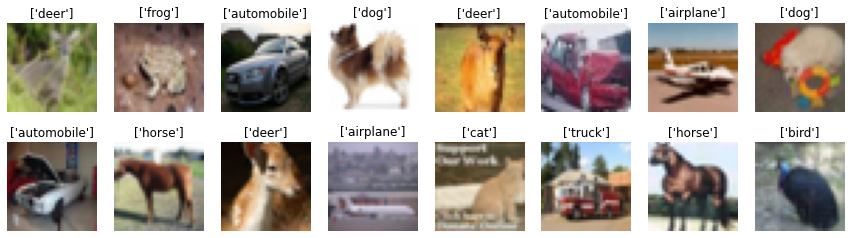

In [4]:
# show random images from train

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :]/255)
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

# Prepare data

* normalize the input like $x_{\text{norm}} = \frac{x}{255} - 0.5$
* We need to convert class labels to one-hot encoded vectors. Use `keras.utils.to_categorical`.

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)

y_train2 = tf.keras.utils.to_categorical(y_train, dtype='float32')
y_val2 = tf.keras.utils.to_categorical(y_val, dtype='float32')
y_test2 = tf.keras.utils.to_categorical(y_test, dtype='float32')

X_train2 = X_train / 255 - 0.5 ### YOUR CODE HERE
X_val2 = X_val/255 - 0.5
X_test2 = X_test/255 - 0.5

# Define CNN architecture

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```


Train it with Adam optimizer with default params.

In [7]:
import keras.initializers as init
# import keras.regularizers as regularizers

net = Sequential()

net.add(Conv2D(10, (3, 3), activation='relu', kernel_initializer=init.RandomNormal(stddev=0.1), input_shape=(32, 32, 3)))
net.add(MaxPooling2D((3, 3)))

net.add(Flatten())
net.add(Dense(100, activation='relu', kernel_initializer=init.RandomNormal(stddev=0.1)))
net.add(Dropout(0.10))

net.add(Dense(10, activation='softmax'))

net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 101,390
Trainable params: 101,390
Non-trainable params: 0
__________________________________________________

In [8]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

net.compile(optimizer = keras.optimizers.Adam(), loss=loss_function, metrics=['accuracy'])
training_history = net.fit(X_train2, y_train2, epochs=10, batch_size=500, validation_data=(X_val2, y_val2))

Epoch 1/10
70/70 [==============================] - 4s 54ms/step - loss: 2.1173 - accuracy: 0.2270 - val_loss: 1.7228 - val_accuracy: 0.3923
Epoch 2/10
70/70 [==============================] - 3s 45ms/step - loss: 1.6941 - accuracy: 0.4004 - val_loss: 1.5252 - val_accuracy: 0.4676
Epoch 3/10
70/70 [==============================] - 3s 44ms/step - loss: 1.5289 - accuracy: 0.4579 - val_loss: 1.4212 - val_accuracy: 0.5035
Epoch 4/10
70/70 [==============================] - 3s 44ms/step - loss: 1.4300 - accuracy: 0.4960 - val_loss: 1.3388 - val_accuracy: 0.5315
Epoch 5/10
70/70 [==============================] - 3s 44ms/step - loss: 1.3394 - accuracy: 0.5251 - val_loss: 1.2783 - val_accuracy: 0.5487
Epoch 6/10
70/70 [==============================] - 3s 44ms/step - loss: 1.2781 - accuracy: 0.5464 - val_loss: 1.2452 - val_accuracy: 0.5607
Epoch 7/10
70/70 [==============================] - 3s 44ms/step - loss: 1.2282 - accuracy: 0.5631 - val_loss: 1.1959 - val_accuracy: 0.5771
Epoch 8/10
70

In [9]:
net.evaluate(X_test2, y_test2)

313/313 [==============================] - 1s 2ms/step - loss: 1.1477 - accuracy: 0.5958


[1.1476536989212036, 0.59579998254776]

### Second step (after you've trained it)

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer

In [10]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    ### YOUR CODE HERE
    model.add(Conv2D(10, (3, 3), activation='relu', kernel_initializer=init.RandomNormal(stddev=0.1), input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3, 3)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer=init.RandomNormal(stddev=0.1)))
    model.add(Dropout(0.10))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [11]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 10)        280       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 10)        40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               100100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [12]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer = keras.optimizers.Adam(), loss=loss_function, metrics=['accuracy'])
training_history = model.fit(X_train2, y_train2, epochs=10, batch_size=500, validation_data=(X_val2, y_val2))

Epoch 1/10
70/70 [==============================] - 6s 87ms/step - loss: 3.0396 - accuracy: 0.2199 - val_loss: 2.2156 - val_accuracy: 0.2704
Epoch 2/10
70/70 [==============================] - 6s 84ms/step - loss: 1.6743 - accuracy: 0.4113 - val_loss: 2.1257 - val_accuracy: 0.3008
Epoch 3/10
70/70 [==============================] - 6s 85ms/step - loss: 1.4877 - accuracy: 0.4714 - val_loss: 2.0133 - val_accuracy: 0.3449
Epoch 4/10
70/70 [==============================] - 6s 87ms/step - loss: 1.3860 - accuracy: 0.5116 - val_loss: 1.8835 - val_accuracy: 0.3840
Epoch 5/10
70/70 [==============================] - 6s 87ms/step - loss: 1.3030 - accuracy: 0.5395 - val_loss: 1.7282 - val_accuracy: 0.4197
Epoch 6/10
70/70 [==============================] - 6s 85ms/step - loss: 1.2324 - accuracy: 0.5611 - val_loss: 1.5278 - val_accuracy: 0.4987
Epoch 7/10
70/70 [==============================] - 6s 87ms/step - loss: 1.1671 - accuracy: 0.5883 - val_loss: 1.4026 - val_accuracy: 0.5211
Epoch 8/10
70

In [13]:
model.evaluate(X_test2, y_test2)

313/313 [==============================] - 1s 3ms/step - loss: 1.1619 - accuracy: 0.5874


[1.161881446838379, 0.5874000191688538]

# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [14]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)


# fit model
model.fit(
    X_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    shuffle=True,
)

Epoch 1/10
1094/1094 [==============================] - 10s 9ms/step - loss: 2.0353 - accuracy: 0.3499 - val_loss: 1.3269 - val_accuracy: 0.5205
Epoch 2/10
1094/1094 [==============================] - 10s 9ms/step - loss: 1.3186 - accuracy: 0.5316 - val_loss: 1.3542 - val_accuracy: 0.5270
Epoch 3/10
1094/1094 [==============================] - 9s 9ms/step - loss: 1.1340 - accuracy: 0.5956 - val_loss: 1.1265 - val_accuracy: 0.6028
Epoch 4/10
1094/1094 [==============================] - 10s 9ms/step - loss: 1.0299 - accuracy: 0.6325 - val_loss: 1.1122 - val_accuracy: 0.6107
Epoch 5/10
1094/1094 [==============================] - 10s 9ms/step - loss: 0.9531 - accuracy: 0.6636 - val_loss: 1.0655 - val_accuracy: 0.6259
Epoch 6/10
1094/1094 [==============================] - 10s 9ms/step - loss: 0.8869 - accuracy: 0.6848 - val_loss: 1.0856 - val_accuracy: 0.6230
Epoch 7/10
1094/1094 [==============================] - 11s 10ms/step - loss: 0.8129 - accuracy: 0.7117 - val_loss: 1.0855 - val_ac

In [15]:
# save weights to file
model.save_weights("weights_1.h5")

In [16]:
# load weights from file (can call without model.fit)
model.load_weights("weights_1.h5")

# Evaluate model

In [22]:
# make test predictions
y_pred_test = model.predict_proba(X_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

print(y_pred_test_classes)
y_test

[5 1 8 ... 5 1 7]


array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]], dtype=uint8)

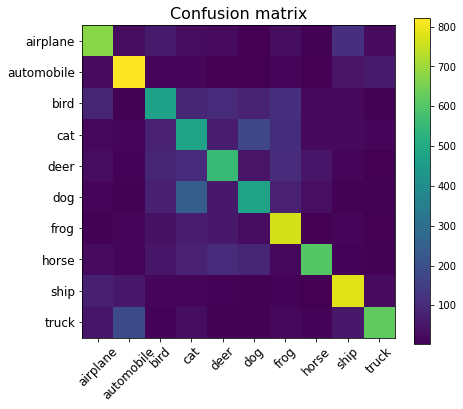

Test accuracy: 0.6248


In [23]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

In [28]:
# inspect preditions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

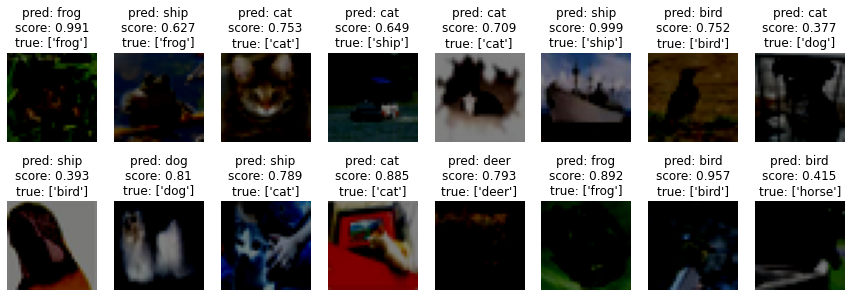

In [41]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test2[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Main: Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets. After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([keras docs](https://keras.io/))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * https://keras.io/layers/writing-your-own-keras-layers/
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way

In [162]:
import keras.regularizers as regularizers

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    # I made dozens of different NN's with overnight trainings with 100epochs, 
    # as well as a lot of research and picked a vgg-type network
    # made a manual tuning of parameters all the paraemeters (number of filters, dropout, etc.)
    # tried a scheme, when we have Conv2D layers (not doubled), but this gives lower outputs.
    # also, tried different sets of activations.

    model = Sequential()
    
    ### YOUR CODE HERE
    
    model.add(Conv2D(8, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [6]:
INIT_LR = 3e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 30

K.clear_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)


# fit model
model.fit(
    X_train2, y_train2,  
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val2, y_val2),
    shuffle=True,
)

Epoch 1/30
1094/1094 [==============================] - 11s 7ms/step - loss: 2.2092 - accuracy: 0.3358 - val_loss: 1.3346 - val_accuracy: 0.5480
Epoch 2/30
1094/1094 [==============================] - 7s 7ms/step - loss: 1.3484 - accuracy: 0.5367 - val_loss: 1.0485 - val_accuracy: 0.6519
Epoch 3/30
1094/1094 [==============================] - 7s 7ms/step - loss: 1.1267 - accuracy: 0.6239 - val_loss: 0.9372 - val_accuracy: 0.7023
Epoch 4/30
1094/1094 [==============================] - 7s 7ms/step - loss: 0.9690 - accuracy: 0.6891 - val_loss: 0.8956 - val_accuracy: 0.7143
Epoch 5/30
1094/1094 [==============================] - 7s 7ms/step - loss: 0.8607 - accuracy: 0.7326 - val_loss: 0.8165 - val_accuracy: 0.7530
Epoch 6/30
1094/1094 [==============================] - 7s 7ms/step - loss: 0.7610 - accuracy: 0.7736 - val_loss: 0.7830 - val_accuracy: 0.7761
Epoch 7/30
1094/1094 [==============================] - 7s 7ms/step - loss: 0.6862 - accuracy: 0.8046 - val_loss: 0.7892 - val_accuracy

In [7]:
# save weights to file
model.save_weights("weights_2.h5")

# load weights from file (can call without model.fit)
model.load_weights("weights_2.h5")

In [8]:
model.evaluate(X_test2, y_test2)

313/313 [==============================] - 1s 4ms/step - loss: 1.0336 - accuracy: 0.8047


[1.0335749387741089, 0.8047000169754028]

In [ ]:
#### now we add a data augmentation and train the SAME MODEL

In [12]:
from keras.preprocessing.image import ImageDataGenerator

INIT_LR = 3e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 30

K.clear_session()  # clear default graph
model = make_model()  # define our model

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train2)


# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# fit model
model.fit_generator(datagen.flow(X_train2, y_train2, batch_size=BATCH_SIZE), epochs=EPOCHS, validation_data=(X_val2,y_val2))

Epoch 1/30
1094/1094 [==============================] - 22s 19ms/step - loss: 2.4243 - accuracy: 0.3085 - val_loss: 1.4499 - val_accuracy: 0.5072
Epoch 2/30
1094/1094 [==============================] - 20s 19ms/step - loss: 1.5307 - accuracy: 0.4699 - val_loss: 1.5019 - val_accuracy: 0.5325
Epoch 3/30
1094/1094 [==============================] - 20s 19ms/step - loss: 1.3263 - accuracy: 0.5529 - val_loss: 1.1317 - val_accuracy: 0.6442
Epoch 4/30
1094/1094 [==============================] - 20s 19ms/step - loss: 1.1770 - accuracy: 0.6154 - val_loss: 1.2315 - val_accuracy: 0.6293
Epoch 5/30
1094/1094 [==============================] - 20s 19ms/step - loss: 1.0843 - accuracy: 0.6536 - val_loss: 0.9431 - val_accuracy: 0.7068
Epoch 6/30
1094/1094 [==============================] - 20s 19ms/step - loss: 1.0155 - accuracy: 0.6837 - val_loss: 0.9562 - val_accuracy: 0.7181
Epoch 7/30
1094/1094 [==============================] - 20s 19ms/step - loss: 0.9499 - accuracy: 0.7109 - val_loss: 0.8491 -

In [122]:
# save weights to file
model.save_weights("weights_2_augmented.h5")

In [164]:
# load weights from file (can call without model.fit)
model.load_weights("weights_2_augmented.h5")

In [13]:
model.evaluate(X_test2, y_test2)

313/313 [==============================] - 1s 3ms/step - loss: 0.7056 - accuracy: 0.8245


[0.705604076385498, 0.8245000243186951]

In [ ]:
### nice! ~82.5 accuracy with the same parameters for 30 epochs!

In [104]:
# finally, I train a model, that I found in different sources (relu changed to elu in fact)

In [146]:
def make_model_augmented():
    model = Sequential()
    
    ### YOUR CODE HERE
    
    model.add(Conv2D(32, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-4), input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(64, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
 
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), activation='elu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    
    return model

In [147]:
from keras.preprocessing.image import ImageDataGenerator

INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 64
EPOCHS = 10

K.clear_session()  # clear default graph
model = make_model_augmented()  # define our model

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(X_train2)


# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.RMSprop(lr=0.001,decay=1e-6),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

In [10]:
# fit model
model.fit_generator(datagen.flow(X_train2, y_train2, batch_size=BATCH_SIZE), epochs=20, validation_data=(X_val2,y_val2))

Epoch 1/20
547/547 [==============================] - 54s 37ms/step - loss: 2.4981 - accuracy: 0.3265 - val_loss: 1.4699 - val_accuracy: 0.5187
Epoch 2/20
547/547 [==============================] - 19s 36ms/step - loss: 1.4859 - accuracy: 0.5256 - val_loss: 1.2262 - val_accuracy: 0.6182
Epoch 3/20
547/547 [==============================] - 19s 35ms/step - loss: 1.2278 - accuracy: 0.6039 - val_loss: 1.2665 - val_accuracy: 0.6307
Epoch 4/20
547/547 [==============================] - 19s 35ms/step - loss: 1.1073 - accuracy: 0.6453 - val_loss: 0.9986 - val_accuracy: 0.6968
Epoch 5/20
547/547 [==============================] - 19s 35ms/step - loss: 1.0198 - accuracy: 0.6729 - val_loss: 0.9142 - val_accuracy: 0.7242
Epoch 6/20
547/547 [==============================] - 19s 35ms/step - loss: 0.9664 - accuracy: 0.6946 - val_loss: 0.8636 - val_accuracy: 0.7438
Epoch 7/20
547/547 [==============================] - 19s 35ms/step - loss: 0.9215 - accuracy: 0.7124 - val_loss: 0.8399 - val_accuracy:

In [126]:
# save weights to file
model.save_weights("weights_3_augmented.h5")

In [150]:
# load weights from file (can call without model.fit)
model.load_weights("weights_3_augmented.h5")

In [151]:
model.evaluate(X_test2, y_test2)

313/313 [==============================] - 6s 20ms/step - loss: 0.6501 - accuracy: 0.8211


[0.6500945091247559, 0.8210999965667725]

In [ ]:
# not bad! in fact here we have 78.5% in 10 epochs and 82.1 in 22 epochs

In [ ]:
# finally, let's get something higher. I take the CNN2 with data augmentation and just train it with smaller lr and for 200 epochs

In [ ]:
import keras.regularizers as regularizers

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    # I made dozens of different NN's with overnight trainings with 100epochs, 
    # as well as a lot of research and picked a vgg-type network
    # made a manual tuning of parameters all the paraemeters (number of filters, dropout, etc.)
    # tried a scheme, when we have Conv2D layers (not doubled), but this gives lower outputs.
    # also, tried different sets of activations.

    model = Sequential()
    
    ### YOUR CODE HERE
    
    model.add(Conv2D(8, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4), input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
 
    model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(1e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [165]:
### commenting this as of huge output

# INIT_LR = 1e-3  # initial learning rate
# BATCH_SIZE = 64
# EPOCHS = 200

# K.clear_session()  # clear default graph
# model = make_model()  # define our model

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     )
# datagen.fit(X_train2)


# # prepare model for fitting (loss, optimizer, etc)
# model.compile(
#     loss='categorical_crossentropy',  # we train 10-way classification
#     optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD
#     metrics=['accuracy']  # report accuracy during training
# )

# # fit model
# model.fit_generator(datagen.flow(X_train2, y_train2, batch_size=BATCH_SIZE), epochs=EPOCHS, validation_data=(X_val2,y_val2), verbose = 1)

In [ ]:
# save weights to file
model.save_weights("weights_last.h5")

# load weights from file (can call without model.fit)
model.load_weights("weights_last.h5")

In [21]:
model.evaluate(X_test2, y_test2)

313/313 [==============================] - 1s 3ms/step - loss: 0.5887 - accuracy: 0.8640


[0.5886890292167664, 0.8640000224113464]

# Ok, after couple of active days of tries my results:


## CNN 1:

* Conv2D(10, (3, 3), ‘relu’) -> MaxPooling2D((3, 3)) -> Dense(100, ‘relu’) -> Dense(10, 'softmax'))
* epochs=10, batch_size=500, Adam(default)
* ~59.5% accuracy 

## CNN 1 + BatchNormalization:

* Conv2D(10, (3, 3), ‘relu’) -> BN -> MaxPooling2D((3, 3)) -> Dense(100, ‘relu’) -> Dense(10, 'softmax'))
* epochs=10, batch_size=500, Adam(default)
* ~58.7% accuracy 

## CNN 1 + BatchNormalization + optimizer hyperparam tuning :

* Conv2D(10, (3, 3), ‘relu’) -> BN -> MaxPooling2D((3, 3)) -> Dense(100, ‘relu’) -> Dense(10, 'softmax'))
* epochs=10, batch_size=32, Adam(lr=5e-3)
* weights saved: weights_1.h5
* ~62.5% accuracy 


-------------------
## CNN 2 (Conv2D's, BN's, Dropout's, regularizations):

* Conv2D(8, (3, 3), ‘relu’) -> BN -> Conv2D(16, (3, 3), ‘relu’) -> BN -> MaxPooling2D((3, 3)) -> Dropout(0.2) ->
* Conv2D(32, (3, 3), ‘relu’) -> BN -> Conv2D(64, (3, 3), ‘relu’) -> BN -> MaxPooling2D((3, 3)) -> Dropout(0.2) ->
* Conv2D(128, (3, 3), ‘relu’) -> BN -> Conv2D(256, (3, 3), ‘relu’) -> BN -> MaxPooling2D((3, 3)) -> Dropout(0.2) ->
* Dense(100, ‘elu’) -> Dropout(0.1) -> Dense(10, 'softmax'))
* epochs=30, batch_size=32, Adamax(lr=3e-3) 
* weights saved: weights_2.h5
* ~80.5% accuracy 

## CNN 2 (Conv2D's, BN's, Dropout's, regularizations) + data augmentation:

* epochs=10, batch_size=32, Adamax(lr=5e-3) , data augmentation
* weights saved: weights_2_augmented.h5
* ~82.5% accuracy 

-----------
## CNN 3 ~ the same structure with different filters + data augmentation:
* Conv2D(32, (3, 3), ‘elu’) -> BN -> Conv2D(32, (3, 3), ‘elu’) -> BN -> MaxPooling2D((3, 3)) -> Dropout(0.2) ->
* Conv2D(64, (3, 3), ‘elu’) -> BN -> Conv2D(64, (3, 3), ‘elu’) -> BN -> MaxPooling2D((3, 3)) -> Dropout(0.3) ->
* Conv2D(128, (3, 3), ‘elu’) -> BN -> Conv2D(128, (3, 3), ‘elu’) -> BN -> MaxPooling2D((3, 3)) -> Dropout(0.4) ->
* Dense(10, 'softmax'))
* epochs=22, batch_size=64,RMSProp(lr=5e-3), data augmentation
* weights saved: weights_3_augmented.h5
* ~82.1% accuracy 

----

## FINALLY: CNN2 with 200 epochs and 1e-3 learning rate
* 86.4% accuracy

## Accuracies:
* CNN1:                ~59.5%
* CNN1 + BN:           ~58.7%
* CNN1 + hyperparams:  ~62.5%
* CNN2:                ~80.5%
* CNN2 + data augment: ~82.5%
* CNN3:                ~82.1%  

* CNN2 more learning:  ~86.4%

In [ ]:
# after huge time wasted here I found out that trainings on GPU are ~10 times faster ;)

# generally, this task was truly interesting, I've learned a lot of new technical things.